# 2018년 랜덤포레스트

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split
from xgboost import XGBRFRegressor, XGBRegressor

In [375]:
df_raw = pd.read_pickle("/home/pirl/Downloads/merge_F_검색량추가190804_SW.pkl")

In [376]:
df_raw["Calendar Day일 2"] = pd.to_datetime(df_raw["Calendar Day일 2"])

In [377]:
df_raw = df_raw[df_raw["Calendar Day일 2"] < '2018-10-01']

In [378]:

df_raw = df_raw[df_raw['Sales (Bag)']>0]

df_raw = df_raw[df_raw['Sales (Bag)']>=1000]
df_raw = df_raw[df_raw['Sales (Bag)']<500]

In [379]:
df_raw["yearmoth"] =df_raw["Calendar Day일 2"].astype(str).str[:7]

In [380]:
df = df_raw.groupby(["CUSTOMER NAME","KF규격","지역","구군","Calendar Day일 2"]).mean()
df[['금액','Sales (Bag)','Sales SU','박스입수','수량(CS)','UPC']] =df_raw.groupby(["CUSTOMER NAME","KF규격","지역","구군","Calendar Day일 2"])[['금액','Sales (Bag)','Sales SU','박스입수','수량(CS)','UPC']].sum()

df.head()

UPC  Sales (Bag)  \
CUSTOMER NAME KF규격 지역 구군  Calendar Day일 2                              
(주)지에스리테일 본부  0    경기 가평군 2017-01-02       8.800000e+12            1   
                          2017-05-26       1.760000e+13            6   
                          2017-07-12       2.640000e+13            7   
                          2018-01-27       2.640000e+13           33   
                          2018-05-06       4.400000e+13           29   

                                           Sales SU  박스입수  수량(CS)     금액  \
CUSTOMER NAME KF규격 지역 구군  Calendar Day일 2                                  
(주)지에스리테일 본부  0    경기 가평군 2017-01-02            1.0    50     0.0   3000   
                          2017-05-26            3.0    80     0.2  21000   
                          2017-07-12            2.0   150     0.1  20200   
                          2018-01-27            0.0   130     0.7  96180   
                          2018-05-06            1.0   196     0.7  82000   

                                                    가격       인구  \
CUSTOMER NAME KF규격 지역 구군  Calendar Day일 2                         
(주)지에스리테일 본부  0    경기 가평군 2017-01-02       3000.000000  62457.0   
                          2017-05-26       3500.000000  62586.0   
                          2017-07-12       2733.333333  62830.0   
                          2018-01-27       3121.666667  62814.0   
                          2018-05-06       3465.400000  63006.0   

                                           선행종합지수(2015=100)  동행종합지수(2015=100)  \
CUSTOMER NAME KF규격 지역 구군  Calendar Day일 2                                       
(주)지에스리테일 본부  0    경기 가평군 2017-01-02                  106.8             105.7   
                          2017-05-26                  108.7             107.0   
                          2017-07-12                  109.9             107.3   
                          2018-01-27                  111.9             108.3   
                          2018-05-06                  112.8             109.4   

                                           ...  일사(MJ/m2)    적설(cm)  \
CUSTOMER NAME KF규격 지역 구군  Calendar Day일 2  ...                        
(주)지에스리테일 본부  0    경기 가평군 2017-01-02       ...   0.449091  0.000000   
                          2017-05-26       ...   1.547333  0.000000   
                          2017-07-12       ...   0.954000  0.000000   
                          2018-01-27       ...   0.950909  2.972917   
                          2018-05-06       ...   0.452000  0.000000   

                                           3시간신적설(cm)  전운량(10분위)  중하층운량(10분위)  \
CUSTOMER NAME KF규격 지역 구군  Calendar Day일 2                                       
(주)지에스리테일 본부  0    경기 가평군 2017-01-02              0.0   7.611111     6.958333   
                          2017-05-26              0.0   1.500000     1.541667   
                          2017-07-12              0.0   7.277778     6.227273   
                          2018-01-27              0.0   0.444444     0.875000   
                          2018-05-06              0.0   9.650000     6.173913   

                                           최저운고(100m )      시정(10m)  \
CUSTOMER NAME KF규격 지역 구군  Calendar Day일 2                             
(주)지에스리테일 본부  0    경기 가평군 2017-01-02          9.250000   371.066667   
                          2017-05-26         13.444444  2001.816667   
                          2017-07-12          4.650000   883.600000   
                          2018-01-27         46.600000  1384.566667   
                          2018-05-06          8.913043  1227.083333   

                                            지면온도(°C)  미세검색량  초미세검색량  
CUSTOMER NAME KF규격 지역 구군  Calendar Day일 2                            
(주)지에스리테일 본부  0    경기 가평군 2017-01-02        1.745000    7.0     5.0  
                          2017-05-26       24.369167   11.0     5.0  
                          2017-07-12       29.936667   13.0     6.0  
                          2018-01-27       -5.636667    9.0   

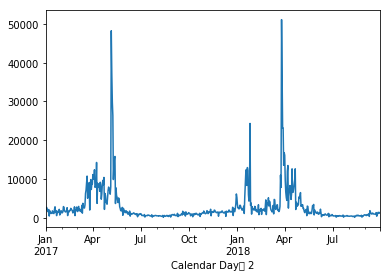

In [381]:
df_raw.groupby(["Calendar Day일 2"])["Sales (Bag)"].sum().plot()

In [382]:
df_true = df.reset_index()
df_true.columns

Index(['CUSTOMER NAME', 'KF규격', '지역', '구군', 'Calendar Day일 2', 'UPC',
       'Sales (Bag)', 'Sales SU', '박스입수', '수량(CS)', '금액', '가격', '인구',
       '선행종합지수(2015=100)', '동행종합지수(2015=100)', '후행종합지수(2015=100)', 'gdp', '연령',
       '평균소득', 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25', 'month', 'day',
       '기온(°C)', '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)', '증기압(hPa)',
       '이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)', '일조(hr)', '일사(MJ/m2)', '적설(cm)',
       '3시간신적설(cm)', '전운량(10분위)', '중하층운량(10분위)', '최저운고(100m )', '시정(10m)',
       '지면온도(°C)', '미세검색량', '초미세검색량'],
      dtype='object')

In [383]:
df_0 = df_true

In [384]:
df_0.drop(['금액','Sales SU','수량(CS)','UPC','day',"Calendar Day일 2","박스입수"], axis=1, inplace=True)

In [385]:
df_0.dropna(inplace=True)
df_0.month = df_0.month.astype(str)
df_0 = pd.get_dummies(df_0)
df_0.head()


,Sales (Bag),가격,인구,선행종합지수(2015=100),동행종합지수(2015=100),후행종합지수(2015=100),gdp,연령,평균소득,SO2,...,month_11.0,month_12.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0
0,1,3000.000000,62457.0,106.8,105.7,105.1,384682.7,47.0,1209301.0,0.004875,...,0,0,0,0,0,0,0,0,0,0
1,6,3500.000000,62586.0,108.7,107.0,106.3,387115.3,47.1,1209301.0,0.003000,...,0,0,0,0,0,1,0,0,0,0
2,7,2733.333333,62830.0,109.9,107.3,106.9,392515.9,47.1,1209301.0,0.003000,...,0,0,0,0,0,0,0,1,0,0
3,33,3121.666667,62814.0,111.9,108.3,108.7,395605.8,47.5,1209301.0,0.004955,...,0,0,0,0,0,0,0,0,0,0
4,29,3465.400000,63006.0,112.8,109.4,110.0,397959.2,47.7,1209301.0,0.002125,...,0,0,0,0,0,1,0,0,0,0


In [386]:
#종속변수, 독립변수 분할
df_raw_y = df_0['Sales (Bag)']
df_raw_x = df_0.drop(['Sales (Bag)'],axis=1,inplace=False)
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,df_raw_y, test_size=0.3,random_state=1234)

In [387]:
tree_uncustumized = XGBRegressor(random_state=1234)
tree_uncustumized.fit(df_train_x,df_train_y)

print(tree_uncustumized.score(df_train_x,df_train_y))
()
print(tree_uncustumized.score(df_test_x,df_test_y))

/home/pirl/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:36:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.5768168753268832
0.4407916705353273


In [388]:
tree_uncustumized = RandomForestRegressor(random_state=1234)
tree_uncustumized.fit(df_train_x,df_train_y)

print(tree_uncustumized.score(df_train_x,df_train_y))

print(tree_uncustumized.score(df_test_x,df_test_y))

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8653921930731819
0.478842075568067


In [389]:
train_score = []
validation_score = []

para_n_tree = [n_tree*10 for n_tree in range(1,13)]

for v_n_estimator in para_n_tree:
    rf =RandomForestRegressor(random_state=1234,n_estimators=v_n_estimator)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    validation_score.append(rf.score(df_test_x,df_test_y))
    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] =para_n_tree
df_score_n["TrainScore"] =train_score
df_score_n["ValidationScore"] =validation_score
df_score_n.round(3)

,n_estimators,TrainScore,ValidationScore
0,10,0.865,0.479
1,20,0.896,0.507
2,30,0.906,0.507
3,40,0.912,0.496
4,50,0.915,0.497
5,60,0.912,0.506
6,70,0.912,0.509
7,80,0.914,0.512
8,90,0.915,0.514
9,100,0.913,0.511


In [390]:
train_score = []
val_score = []

para_n_leaf = [n_leaf*1 for n_leaf in range(1,5)]

for v_min_samples_leaf in para_n_leaf :
    rf = RandomForestRegressor(random_state=1234, n_estimators=90, min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    val_score.append(rf.score(df_test_x,df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSampleLeaf"] =para_n_leaf
df_score_leaf["TrainScore"] =train_score
df_score_leaf["ValidationScore"] =val_score

In [391]:
df_score_leaf.round(3)

,MinSampleLeaf,TrainScore,ValidationScore
0,1,0.915,0.514
1,2,0.804,0.505
2,3,0.727,0.474
3,4,0.670,0.446


In [394]:
train_score = []
test_score = []

para_split = [n_split*2 for n_split in range(4,8)]

for v_min_samples_split in para_split :
    rf = RandomForestRegressor(random_state=1234, n_estimators=90,min_samples_leaf=1, min_samples_split=v_min_samples_split)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSampleSplit"] =para_split
df_score_split["TrainScore"] =train_score
df_score_split["ValidationScore"] =test_score

In [395]:
df_score_split.round(3)

,MinSampleSplit,TrainScore,ValidationScore
0,8,0.821,0.505
1,10,0.799,0.501
2,12,0.772,0.491
3,14,0.745,0.481


In [399]:
train_score = []
test_score = []

para_depth = [depth for depth in range(15,17)]

for v_max_depth in para_depth :
    rf = RandomForestRegressor(random_state=1234, n_estimators=90,min_samples_leaf=1,min_samples_split=2, max_depth=v_max_depth)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["MaxDepth"] =para_depth
df_score_depth["TrainScore"] =train_score
df_score_depth["ValidationScore"] =test_score
df_score_depth.round(3)

,MaxDepth,TrainScore,ValidationScore
0,15,0.903,0.508
1,16,0.907,0.509


In [405]:
train_score=[]
test_score=[]

gf_final =XGBRegressor(random_state=1234,n_estimators=84, learning_rate=0.216, max_depth=3, tree_method='gpu_hist')
gf_final.fit(df_train_x,df_train_y)
train_score.append(gf_final.score(df_train_x,df_train_y))

test_score.append(gf_final.score(df_test_x,df_test_y))
print("Score on training set :" ,(gf_final.score(df_train_x,df_train_y)).round(3))

print("Score on test set :" ,(gf_final.score(df_test_x,df_test_y)).round(3))

/home/pirl/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:34:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Score on training set : 0.626
Score on test set : 0.448


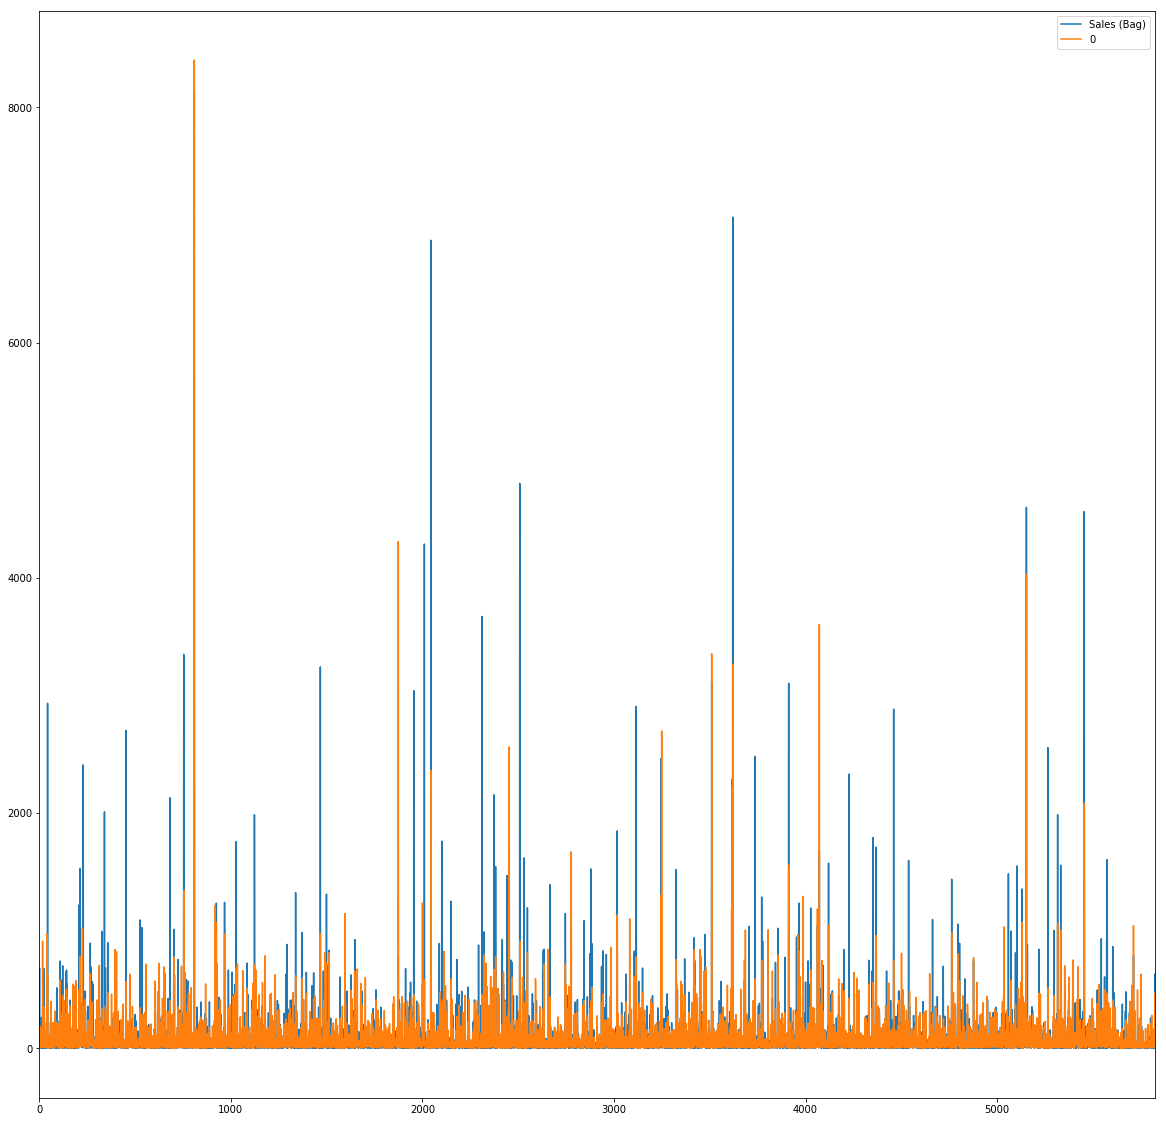

In [403]:
pd.DataFrame(gf_final.predict(df_test_x),df_test_y).reset_index().plot(figsize=(20,20))

In [404]:
pd.DataFrame(gf_final.predict(df_test_x),df_test_y).reset_index()

,Sales (Bag),0
0,11,16.440294
1,685,176.553715
2,3,2.772831
3,4,4.662617
4,95,187.498356
5,23,17.173940
6,49,74.486578
7,12,11.760903
8,12,12.821116
9,212,25.483079


In [445]:
tree_uncustumized = RandomForestRegressor(random_state=1234)
tree_uncustumized.fit(df_train_x,df_train_y)

print(tree_uncustumized.score(df_train_x,df_train_y))

print(tree_uncustumized.score(df_test_x,df_test_y))

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9005473009326179
0.5823262753271471


In [446]:
train_score = []
validation_score = []

para_n_tree = [n_tree*10 for n_tree in range(9,20)]

for v_n_estimator in para_n_tree :
    rf = RandomForestRegressor(random_state=1234,n_estimators=v_n_estimator)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    validation_score.append(rf.score(df_test_x,df_test_y))
    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] =para_n_tree
df_score_n["TrainScore"] =train_score
df_score_n["ValidationScore"] =validation_score

In [ ]:
df_score_depth.round(3)

In [686]:
df_raw.head()

,모름,KF규격,CUSTOMER NAME,Calendar Day일 2,POS Category Code,UPC,품목명,Sales (Bag),Sales SU,박스입수,구분,유통사,SUB-CTG,수량(CS),금액,가격,지역,구군,시점,인구,선행종합지수(2015=100),동행종합지수(2015=100),후행종합지수(2015=100),분기,gdp,연령,평균소득,SO2,CO,O3,NO2,PM10,PM25,month,day,일시,지점,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),증기압(hPa),이슬점온도(°C),현지기압(hPa),해면기압(hPa),일조(hr),일사(MJ/m2),적설(cm),3시간신적설(cm),전운량(10분위),중하층운량(10분위),최저운고(100m ),시정(10m),지면온도(°C),미세검색량,초미세검색량,yearmoth
0,CNX,0,(주)지에스리테일 본부,2017-01-01,MP,8.800000e+12,CNX 황사마스크 대형1P,27,27.0,50,POS,(주)지에스리테일 본부,MP,0.5,49000,1815,경기,평택시,2017-01,472141,106.8,105.7,105.1,2017Q1,384682.7,39.2,1281433,0.004772,0.549275,0.011942,0.026594,89.57971,60.442988,1,1,2017-01-01,경기,0.6675,0.0,0.535833,87.166667,82.925,5.353333,-2.025833,1021.08,1028.6725,0.158182,0.413636,0.0,0.0,6.222222,6.625,9.428571,486.766667,-0.433333,7.0,5.0,2017-01
1,UKM,0,(주)지에스리테일 본부,2017-01-01,MG,8.800000e+12,UKM 크리넥스 입체마스크 성인용 3P 6G x 3EA,28,0.0,50,POS,(주)지에스리테일 본부,MG,0.6,84000,3000,경기,평택시,2017-01,472141,106.8,105.7,105.1,2017Q1,384682.7,39.2,1281433,0.004772,0.549275,0.011942,0.026594,89.57971,60.442988,1,1,2017-01-01,경기,0.6675,0.0,0.535833,87.166667,82.925,5.353333,-2.025833,1021.08,1028.6725,0.158182,0.413636,0.0,0.0,6.222222,6.625,9.428571,486.766667,-0.433333,7.0,5.0,2017-01
2,UKM,0,(주)지에스리테일 본부,2017-01-01,MG,8.800000e+12,UKM 크리넥스 입체마스크 어린이용 3P 6Gx3EA,20,0.0,50,POS,(주)지에스리테일 본부,MG,0.4,57000,2850,경기,평택시,2017-01,472141,106.8,105.7,105.1,2017Q1,384682.7,39.2,1281433,0.004772,0.549275,0.011942,0.026594,89.57971,60.442988,1,1,2017-01-01,경기,0.6675,0.0,0.535833,87.166667,82.925,5.353333,-2.025833,1021.08,1028.6725,0.158182,0.413636,0.0,0.0,6.222222,6.625,9.428571,486.766667,-0.433333,7.0,5.0,2017-01
3,CNX,0,(주)지에스리테일 본부,2017-01-01,MG,8.800000e+12,CNX 황사마스크 성인용3P,1,1.0,50,POS,(주)지에스리테일 본부,MG,0.0,2600,2600,경기,포천시,2017-01,154381,106.8,105.7,105.1,2017Q1,384682.7,43.4,1290713,0.004493,0.843492,0.012630,0.023720,90.76087,87.900000,1,1,2017-01-01,경기,0.6675,0.0,0.535833,87.166667,82.925,5.353333,-2.025833,1021.08,1028.6725,0.158182,0.413636,0.0,0.0,6.222222,6.625,9.428571,486.766667,-0.433333,7.0,5.0,2017-01
4,CNX,KF94,(주)지에스리테일 본부,2017-01-01,MP,8.800000e+12,CNX KF94 방역용 마스크 1입,2,2.0,50,POS,(주)지에스리테일 본부,MP,0.0,5000,2500,경기,포천시,2017-01,154381,106.8,105.7,105.1,2017Q1,384682.7,43.4,1290713,0.004493,0.843492,0.012630,0.023720,90.76087,87.900000,1,1,2017-01-01,경기,0.6675,0.0,0.535833,87.166667,82.925,5.353333,-2.025833,1021.08,1028.6725,0.158182,0.413636,0.0,0.0,6.222222,6.625,9.428571,486.766667,-0.433333,7.0,5.0,2017-01


In [153]:
m = sm.tsa.SARIMAX(df_, order=(1, 2, 1), seasonal_order=(1, 1, 1, 52))
r = m.fit()
print(r.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              money   No. Observations:                  792
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 52)   Log Likelihood              -13601.200
Date:                            Sun, 04 Aug 2019   AIC                          27212.399
Time:                                    13:54:16   BIC                          27235.419
Sample:                                01-01-2017   HQIC                         27221.276
                                     - 03-03-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3519      0.040     -8.817      0.000      -0.430      -0.274
ma.L1         -0.9947      0.044   

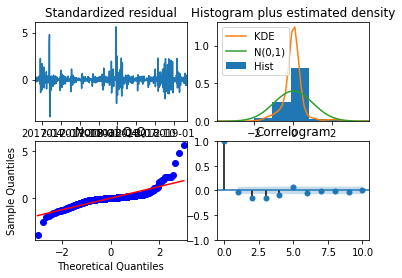

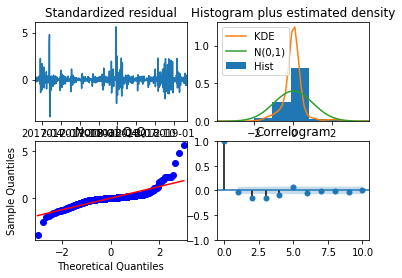

In [154]:
r.plot_diagnostics()

/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


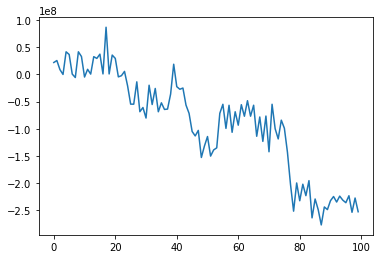

In [155]:
plt.plot(r.simulate(100, initial_state=r.filtered_state[:, -1]))
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
pred = r.predict(tr_end,te_end,exog = exog_test)[1:]
print('SARIMAX model MSE:{}'.format(mean_squared_error(tes,pred)))

TypeError: Timestamp('2019-03-04 00:00:00', freq='D') is not a string

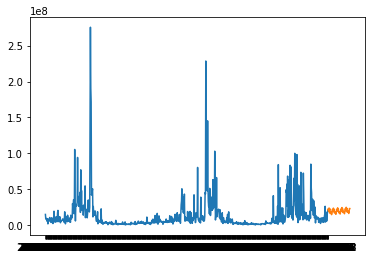

In [109]:
horizon = 60
pred = r.get_prediction(start=len(df_raw), end=len(df_raw) + horizon)
s = df_raw['money'].copy()
s[:-1] = np.nan
s = np.hstack([s, pred.predicted_mean])
ci = pred.conf_int(alpha=0.05)

plt.plot(df_raw['money'])
plt.plot(s)
plt.fill_between(ci.index, ci["lower money"], ci["upper money"], color='r', alpha=0.5)
plt.show()


In [57]:

df_g = df_gangnam[df_gangnam['품목명']=='CNX 황사마스크 대형1P']

# Train and Test 데이터 분할 : 비율 기준 mask 지정(시계열이라 랜덤 추출 불가)
train_size = 0.9
len_idx = len(df_g.index)
mask = (np.arange(len_idx) / len_idx) < train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False])

In [67]:
# Train & Test 데이터 분할 : index 직접 지정
df_CNY_train = df_g[df_g.index <= '2018-03-22'][['Sales (Bag)']]
df_CNY_test = df_g[df_g.index > '2018-03-22'][['Sales (Bag)']]
df_CNY_test.head()

,Sales (Bag)
Calendar Day일 2,
2018-04-15,17
2018-04-18,3
2018-05-12,1
2018-06-15,1
2018-11-11,5


In [70]:
m = sm.tsa.SARIMAX(df_CNY_train, order=(1, 2, 1), seasonal_order=(1, 1, 1, 5))
r = m.fit()
print(r.summary())

                                 Statespace Model Results                                
Dep. Variable:                       Sales (Bag)   No. Observations:                   36
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 5)   Log Likelihood                -129.843
Date:                           Sun, 04 Aug 2019   AIC                            269.686
Time:                                   12:46:58   BIC                            276.523
Sample:                                        0   HQIC                           271.827
                                            - 36                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3396      0.268     -1.267      0.205      -0.865       0.186
ma.L1         -0.9992     90.304     -0.011

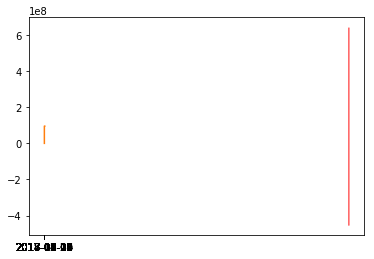

In [76]:
horizon = 60
pred = r.get_prediction(start=len(df), end=len(df) + horizon)
s = df_CNY_train['Sales (Bag)'].copy()
s[:-1] = np.nan
s = np.hstack([s, pred.predicted_mean])
ci = pred.conf_int(alpha=0.05)

plt.plot(df_CNY_train['Sales (Bag)'])
plt.plot(s)
plt.fill_between(ci.index, ci["lower Sales (Bag)"], ci["upper Sales (Bag)"], color='r', alpha=0.5)
plt.show()

AttributeError: 'SARIMAXResults' object has no attribute 'plot_predict'

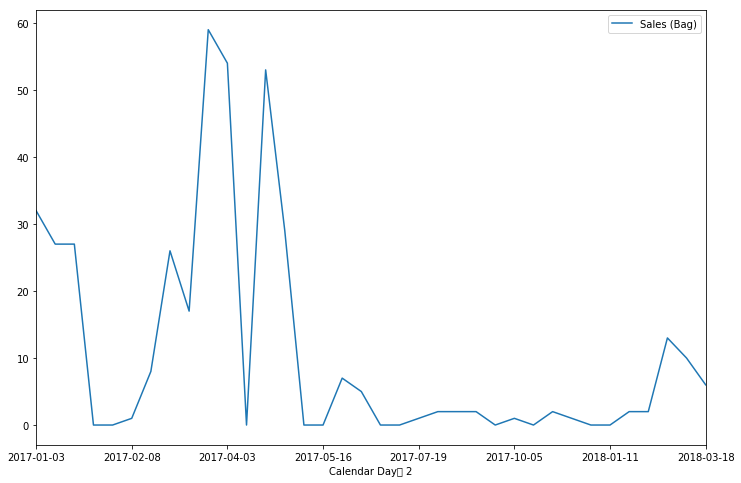

In [71]:
# 예측 시작/종료 날짜 지정
start_time = df_CNY_test.index.min()
end_time = df_CNY_test.index.max()
fig, ax = plt.subplots(figsize=(12,8))
# 예측 전까지 데이터
ax = df_CNY_train.plot(ax = ax)
# 예측 그래프 생성 함수 , start : 예측 시작, end : 예측 종료, plot_insample : 가지고 있는 데이터 중 예측 구간과 겹치는 구간 표시
figs = r.plot_predict(start=start_time, end=end_time, ax=ax, plot_insample=False)

In [156]:
# 전체 기간의 실제값, 예측값 확인
start_time = pd.to_datetime('2016-01-03') # 차분=2 > 시작일자 + 2 이후부터 예측값 생성됨
y_pred = r.predict(start='2017-01-01', end='2019-03-03')

df_merge = df_raw # 실제값 저장

df_merge["예측값"] = y_pred # 예측값 저장 및 변수명 지정
df_merge.head()

,money,예측값
Calendar Day일 2,,
2017-01-01,14930960,0.000000e+00
2017-01-02,8796124,1.976915e+07
2017-01-03,9500876,1.662218e+07
2017-01-04,8284787,1.287299e+07
2017-01-05,6364747,1.130847e+07


In [157]:
df_merge.tail(4)

,money,예측값
Calendar Day일 2,,
2019-02-28,6872981,7.883064e+06
2019-03-01,15795477,1.046552e+07
2019-03-02,18917615,4.342771e+06
2019-03-03,21911191,1.411070e+07


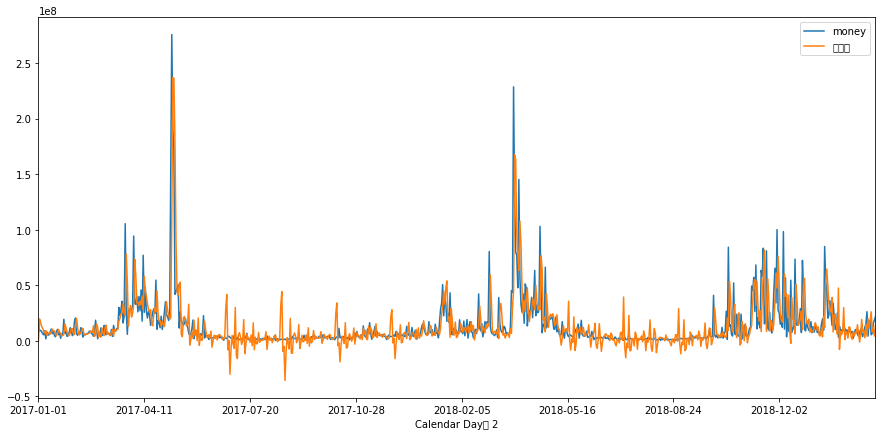

In [158]:
# 추세 그래프 생성 및 확인
df_merge.plot(y=['money', '예측값'], figsize=(15,7))

In [165]:
y_pred = pd.DataFrame(r.predict(start='2017-01-01', end='2019-09-03'))


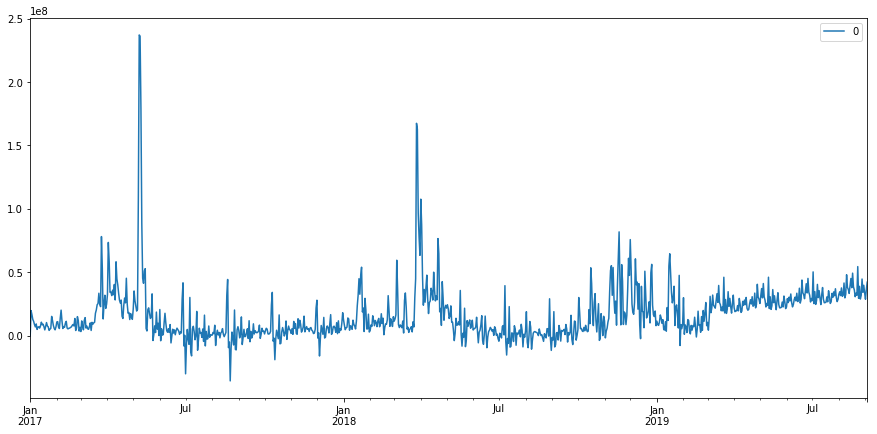

In [166]:
y_pred.plot(y=[0], figsize=(15,7))

## 실습

In [20]:
df_USD.head()

,STD_RATE
APPL_DATE,
2016-01-01,1178.0
2016-01-02,1178.0
2016-01-03,1178.0
2016-01-04,1184.0
2016-01-05,1185.0


In [21]:
# Train and Test 데이터 분할 : 비율 기준 mask 지정(시계열이라 랜덤 추출 불가)
train_size = 0.9
len_idx = len(df_USD.index)
mask = (np.arange(len_idx) / len_idx) < train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False])

In [22]:
# Train & Test 데이터 분할 : index 직접 지정
df_USD_train = df_USD[df_USD.index <= '2016-03-22']
df_USD_test = df_USD[df_USD.index > '2016-03-22']
df_USD_test.head()

,STD_RATE
APPL_DATE,
2016-03-23,1161.0
2016-03-24,1165.0
2016-03-25,1169.0
2016-03-26,1169.0
2016-03-27,1169.0


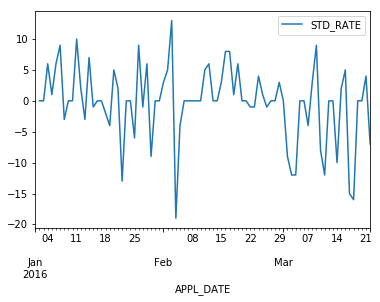

In [23]:
# 1차 차분 : z(t) - z(t-1)
# shift(n) : 앞의 n번째 행의 데이터를 가져옴
df_USD_diff1 = df_USD_train - df_USD_train.shift(1)
df_USD_diff1.plot()

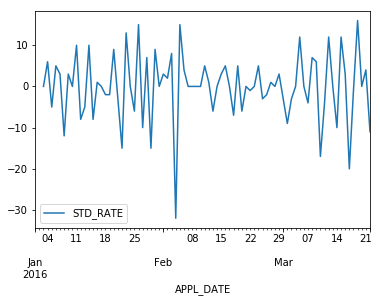

In [24]:
df_USD_diff2 = df_USD_train -2 * (df_USD_train.shift(1)) + (df_USD_train.shift(2))
df_USD_diff2.plot()

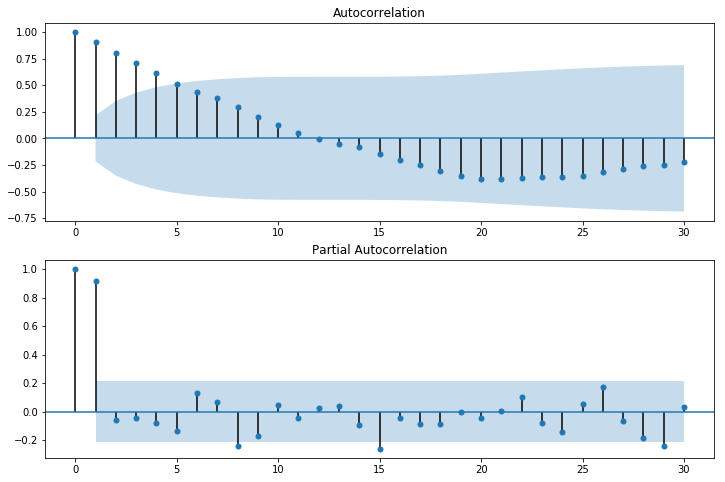

In [25]:
# 자기회귀 최대 p기간 지정
lag_size = 30
fig = plt.figure(figsize=(12, 8))
# acf 그래프를 그릴 공간 생성
ax1 = fig.add_subplot(211)
# 자기상관 함수 그래프 plot_acf 함수 사용
fig = plot_acf(df_USD_train["STD_RATE"], lags=lag_size, ax=ax1)
# pacf 그래프를 그릴 공간 생성
ax2 = fig.add_subplot(212)
# 부분 자기상관 함수 그래프 plot_pacf 함수 사용
fig = plot_pacf(df_USD_train['STD_RATE'], lags=lag_size, ax=ax2)

In [26]:
# Train 데이터 이용, AR(1), l(2, 차분), MA(0)인 ARIMA 모델
ts_model_usd = ARIMA(df_USD_train, order=(1,2,0)) # p,q,d 지정
# 데이터 적합
# trend : 상수 포함 여부 "nc" 이면 상수 미포함, full_ouput: 모든 출력 결과 표시
ts_result_usd = ts_model_usd.fit(trend='c', full_output=True)
print(ts_result_usd.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.STD_RATE   No. Observations:                   80
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -274.800
Method:                       css-mle   S.D. of innovations              7.502
Date:                Fri, 19 Jul 2019   AIC                            555.601
Time:                        16:08:16   BIC                            562.747
Sample:                    01-03-2016   HQIC                           558.466
                         - 03-22-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0502      0.612     -0.082      0.935      -1.249       1.148
ar.L1.D2.STD_RATE    -0.3763      0.104     -3.622      0.001      -0.580      -0.173
                        

/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


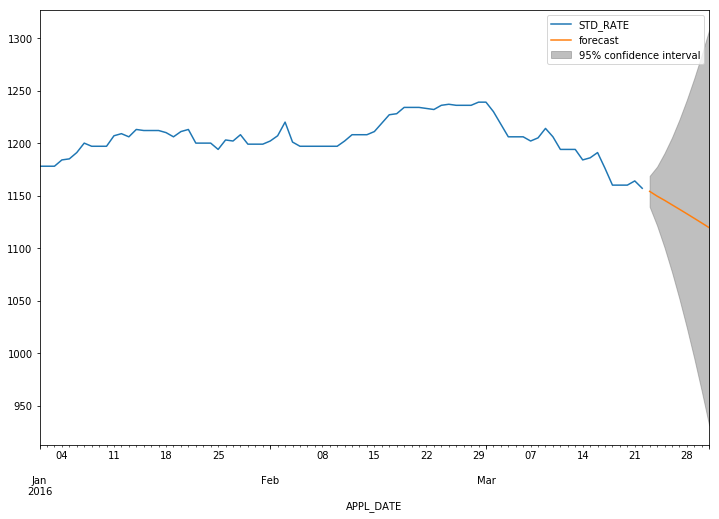

In [27]:
# 예측 시작/종료 날짜 지정
start_time = df_USD_test.index.min()
end_time = df_USD_test.index.max()
fig, ax = plt.subplots(figsize=(12,8))
# 예측 전까지 데이터
ax = df_USD_train.plot(ax = ax)
# 예측 그래프 생성 함수 , start : 예측 시작, end : 예측 종료, plot_insample : 가지고 있는 데이터 중 예측 구간과 겹치는 구간 표시
figs = ts_result_usd.plot_predict(start=start_time, end=end_time, ax=ax, plot_insample=False)

In [28]:
# 전체 기간의 실제값, 예측값 확인
start_time = pd.to_datetime('2016-01-03') # 차분=2 > 시작일자 + 2 이후부터 예측값 생성됨
y_pred = ts_result_usd.predict(start=start_time, end=end_time, typ='levels')
df_merge = df_USD # 실제값 저장
df_merge["예측값"] = y_pred # 예측값 저장 및 변수명 지정
df_merge.head()

,STD_RATE,예측값
APPL_DATE,,
2016-01-01,1178.0,NaN
2016-01-02,1178.0,NaN
2016-01-03,1178.0,1177.949753
2016-01-04,1184.0,1177.930843
2016-01-05,1185.0,1187.672879


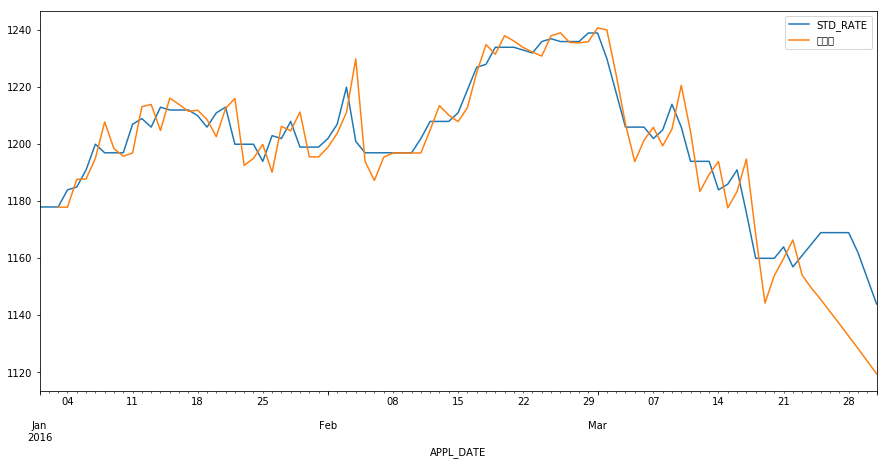

In [29]:
# 추세 그래프 생성 및 확인
df_merge.plot(y=['STD_RATE', '예측값'], figsize=(15,7))